In [1]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv

from hxpr.utils import here

load_dotenv()

True

In [2]:
DATA_DIR = here() / "data"

ELECTION_DATA_DIR = DATA_DIR / "medsl"
HUD_DATA_DIR = DATA_DIR / "hud"

## Process Presidential Election Data

In this section, we open precinct level data and sum it up to the county level

In [3]:
df = pd.read_csv(ELECTION_DATA_DIR / "countypres_2000-2020.csv.xz")

In [4]:
# Just 2020
df = df[df["year"] == 2020].copy()

In [5]:
# Note that Alaska doesn't really have "counties" though it does have "election
# districts". It's very annoying but we'll ignore them for now until we figure out
# a better resolution.
df = df[df["state_po"] != "AK"]

# Moreover, Rhode Island has a slightly odd way of counting votes that includes a
# "Federal Precinct" (I think this is for mail in ballots mostly). Thankfully, this
# state doesn't even appear in our outcome data, so it's fine to exclude them
df = df[df["state_po"] != "RI"]

# For whatever reason, this dataset doesn't setup DC as a county as well
df.loc[df["state_po"] == "DC", "county_fips"] = "11001"

# Then standardize
df["county_fips"] = df["county_fips"].apply(lambda x: f"{int(x):05d}")
df["state_fips"] = df["county_fips"].str[:2]

In [6]:
total_votes_by_county = (
    df.groupby(["state_fips", "county_fips", "party"])["candidatevotes"]
    .sum()
    .reset_index()
)

### Examining the County / ZIP crosswalk

In [7]:
county_df = pd.read_parquet(HUD_DATA_DIR / "COUNTY_ZIP_092021.parquet")
zip_df = pd.read_parquet(HUD_DATA_DIR / "ZIP_COUNTY_092021.parquet")

In [8]:
# Most ZIP codes are contained in a single county
county_df["zipcode"].value_counts().value_counts(normalize=True)

1    0.717079
2    0.206746
3    0.062652
4    0.012282
5    0.000988
6    0.000228
7    0.000025
Name: zipcode, dtype: float64

In [9]:
# And of the ZIP codes that are in 2 counties, most of them are 95% in a single county
# and 80% have at least 80% in a single county
x = county_df["zipcode"].value_counts()
x[x == 2].index

highest_res_ratio = (
    zip_df[zip_df["zipcode"].isin(x[x == 2].index)]
    .groupby("zipcode")["res_ratio"]
    .max()
)
print((highest_res_ratio > 0.95).mean(), (highest_res_ratio > 0.80).mean())

0.5437285644292014 0.8084272415482606


<AxesSubplot:>

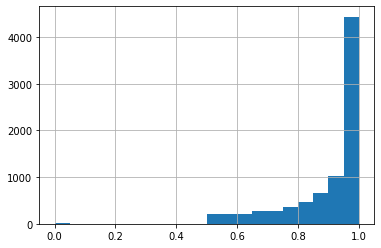

In [10]:
# As a plot
highest_res_ratio.hist(bins=np.arange(0, 1.01, 0.05))

In [11]:
# Still, it's a bit dangerous to attribute to a ZIP the relative partisanship of the
# counties that contain it (think, e.g., about the partisan polarization of Brooklyn)
# Thus, consider this a first pass

two_party_vote_by_county = total_votes_by_county[
    total_votes_by_county["party"].isin(["DEMOCRAT", "REPUBLICAN"])
]

hold_df = two_party_vote_by_county.merge(county_df, on="county_fips")

hold_df["tempered_vote"] = hold_df["candidatevotes"] * hold_df["res_ratio"]
hold_df = (
    hold_df.groupby(["zipcode", "party"])["tempered_vote"]
    .sum()
    .reset_index(name="votes")
)
hold_df["total_votes"] = hold_df.groupby(["zipcode"])["votes"].transform("sum")
hold_df["two_party_vote_share"] = hold_df["votes"] / hold_df["total_votes"]

hold_df.to_parquet(
    DATA_DIR / "phase2" / "zip_code_with_two_party_vote_share_crude.parquet"
)
hold_df.to_csv(
    DATA_DIR / "phase2" / "zip_code_with_two_party_vote_share_crude.csv", index=False
)